# Load libraries

In [1]:
import numpy as np
import os
import pandas as pd

# sklearn libraries for the logistic regression

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# keras libraries for the neural network training

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import models

# Plotting libraries

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [5]:
colors=list(mcolors.TABLEAU_COLORS.values())

# Data standarization for the neural network

In [6]:
# Standarization of the input and output data
# used to train the neural network between ReLU layers
# and calculation of the initial weights used to train
# the whole neural network. 

def st(xmin,xmax,ymin,ymax,array):
    """Vectorized standarization function."""
    if xmax==xmin:
        st = lambda x: (ymin+ymax)/2.0
    else:
        st = lambda x: ymin + (x-xmin)/(xmax-xmin)*(ymax-ymin)
    arr_st = np.vectorize(st)
    return arr_st(array)


def standarize(data,
                   ga1xmin=0.2,ga1xmax=0.8,
                   ga2xmin=0.2,ga2xmax=0.8,
                   ga3xmin=0.2,ga3xmax=0.8,
                   polymin=0.2,polymax=0.8,
                   powymin=0.2,powymax=0.8,
                   angymin=0.2,angymax=0.8):
    
    """Standarize input and output data used to train the neural network
    between ReLU layers. Also calculates the initial weights used to train
    the whole neural network. """
    
    #Gamma_1
    gam1 = data[:,0]
    #Gamma_2
    gam2 = data[:,1]
    #Gamma_3
    gam3 = data[:,2]
    #gam4

    
    #degree of circular polarization
    pola = data[:,3]
    #intensity
    powe = data[:,4]
    #incidence angle
    angl = data[:,5]
    
    ga1min = np.amin(gam1)
    ga1max = np.amax(gam1)
    ga2min = np.amin(gam2)
    ga2max = np.amax(gam2)
    ga3min = np.amin(gam3)
    ga3max = np.amax(gam3)
    
    polmin = np.amin(pola)
    polmax = np.amax(pola)
    powmin = np.amin(powe)
    powmax = np.amax(powe)
    angmin = np.amin(angl)
    angmax = np.amax(angl)
    
    # raw input
    Xr = np.transpose([gam1,gam2,gam3])
    
    # raw output
    Yr = np.transpose([pola,powe,angl])
    
    # standarized input
    Xs = np.transpose([st(ga1min,ga1max,ga1xmin,ga1xmax,gam1),
                    st(ga2min,ga2max,ga2xmin,ga2xmax,gam2),
                    st(ga3min,ga3max,ga3xmin,ga3xmax,gam3)])
    
    # standarized output
    Ys = np.transpose([st(polmin,polmax,polymin,polymax,pola),
                    st(powmin,powmax,polymin,polymax,powe),
                    st(angmin,angmax,angymin,angymax,angl)])
    
    # initial weights used to train the whole neural network
    w0 = np.array([[(ga1xmax-ga1xmin)/(ga1max-ga1min),0.0,0.0],
                   [0.0,(ga2xmax-ga2xmin)/(ga2max-ga2min),0.0],
                   [0.0,0.0,(ga3xmax-ga3xmin)/(ga3max-ga3min)]])
    b0 = np.array([ga1xmin-(ga1xmax-ga1xmin)*ga1min/(ga1max-ga1min),
                   ga2xmin-(ga2xmax-ga2xmin)*ga2min/(ga2max-ga2min),
                   ga3xmin-(ga3xmax-ga3xmin)*ga3min/(ga3max-ga3min)])
    
    wn = np.array([[(polmax-polmin)/(polymax-polymin), 0.0],
                   [0.0, (powmax-powmin)/(powymax-powymin)]])
    bn = np.array([polmin-(polmax-polmin)*polymin/(polymax-polymin),
                   powmin-(powmax-powmin)*powymin/(powymax-powymin)])

        
    return {'Xr': Xr, 'Yr': Yr, 'Xs': Xs, 'Ys': Ys, 'w0': w0, 'b0': b0, 'wn': wn, 'bn': bn}

# Rearange data columns to calculate Gamma1, Gamma2 and Gamma3

In [7]:
# calculate \Gamma_1, \Gamma_2 and \Gamma_3
# column 0: \Gamma_2 (V)
# column 1: \Gamma_3 (V)
# column 2: degree of circular polarization (%)
# column 3: intensity or power (mW)
# column 4: P_c(50mT) (V)
# column 5: P_c(150mT) (V)
# column 6: h =1 (\sigma^-), 2 (X), 3 (\sigma_+)

def arrange_data(data):
    datat = np.transpose(data)
    datas = np.transpose([datat[3] + datat[4], #\Gamma_1
                          datat[3] - datat[4], #\Gamma_2
                          datat[5] / datat[3], #\Gamma_3
                          datat[0],  #degree of circular polarization
                          datat[1],  #power or intensity
                          datat[2],  #incidence angle
                          datat[6]+2]) #h
    return datas


# Error function for the neural network

In [8]:
def get_errors(predictor,X,Y,mode='real',show=True):
    """Error calculation function.
    mode='real' calculates the errors with respect
    to each point of the ouput.
    mode='average' calcualtes the errors with respect
    to the average of all the points."""
    
    Yp = predictor.predict(X)
    
    avY = np.average(Y,axis=0)
    averr = 100*np.average((Yp-Y)**2,axis=0)/avY
    if mode=='average':
        errs = 100*np.abs(Yp-Y)/avY
    else:
        errs = 100*np.abs(Yp-Y)/Y
        
    minerr = np.amin(errs,axis=0)
    maxerr = np.amax(errs,axis=0)
    
    if show :
        print('errors min:',minerr)
        print('errors max:',maxerr)
        print('errors av:', averr)
    
        
    return {'averr': averr, 'maxerr': maxerr, 'minerr': minerr ,'errs':errs}

# Plot predictions

In [9]:
def plot_predictions(predictor,X,Y,
                     s_pred=50,s_true=30,alpha_pred=0.4,alpha_true=0.5,
                     color_pred = 'lightblue',color_true = 'purple',
                     xlabel='$P_e$',ylabel='$P_{exc}$',
                     filename=''):
    
    Yp = predictor.predict(X)
    
    #plot data sets
    Y1 = Yp[:,0]
    Y2 = Yp[:,1]
    y1 = Y[:,0]
    y2 = Y[:,1]
    
    plt.rc('axes', labelsize=20)
    plt.scatter(Y1,Y2,color=color_pred,s=s_pred, alpha=alpha_pred)
    plt.scatter(y1,y2,color=color_true,s=s_true,alpha=alpha_true)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if filename != '' :
        plt.savefig(filename)

plt.show()

# Plot error distributions

In [10]:
def plot_error_distribution(predictor,X,Y,mode='average'):
    
    errors = get_errors(predictor,X,Y,mode=mode,show=False)
    
    histdata1 = np.histogram(np.transpose(errors['errs'])[0])
    histdata2 = np.histogram(np.transpose(errors['errs'])[1])
    counts1 = 100*histdata1[0]/np.shape(X)[0]
    bins1   = histdata1[1]
    counts2 = 100*histdata2[0]/np.shape(X)[0]
    bins2   = histdata2[1]
    
    plt.hist(bins1[:-1], bins1, weights=counts1,color=colors[2],alpha=0.7)
    plt.hist(bins2[:-1], bins2, weights=counts2,color=colors[0],alpha=0.7)
    plt.xlabel('error (%)')
    plt.ylabel('occurrences (%)')

plt.show()

# Generate models WITHOUT and WITH ReLU layers

In [11]:
#Generate model without ReLU layers

def gen_model():
    model = Sequential()
    model.add(Dense(12,input_dim=3,activation='sigmoid'))
    model.add(Dense(12,activation='sigmoid'))
    model.add(Dense(2,activation='sigmoid'))
    
    return model

#Generate model with ReLU layers
def gen_model_relu(model,w0,b0,wn,bn):
    """Generates the model with the two ReLU layers with
    initial the weights w0,b0,wn,bn."""
    
    model_relu = Sequential()
    model_relu.add(Dense(3,input_dim=3,activation='relu'))
    model_relu.add(Dense(12,activation='sigmoid'))
    model_relu.add(Dense(12,activation='sigmoid'))
    model_relu.add(Dense(2,activation='sigmoid'))
    model_relu.add(Dense(2,activation='relu'))
    
    #get weights from the model with out relu layers
    model_weights = model.get_weights()
    #enter weights into the model with relu layers
    model_relu_weights = model_weights[:]
    
    #insert first relu layers initial values 
    model_relu_weights.insert(0,w0)
    model_relu_weights.insert(1,b0)
    
    #insert last relu layers initial values 
    model_relu_weights.append(wn)
    model_relu_weights.append(bn)
    
    #set up weights in the model with relu layers
    model_relu.set_weights(model_relu_weights)
    
    return model_relu


# Read training and test data sets

In [12]:
train_path  = os.path.join('./data/trthe.data')
test_path   = os.path.join('./data/tethe.data')
trexp_path  = os.path.join('./data/trexp.data')
teexp_path  = os.path.join('./data/teexp.data')


tr = np.array(pd.read_csv(train_path,  header=None,encoding='utf-8',delimiter='\t'))
te = np.array(pd.read_csv(test_path,   header=None,encoding='utf-8',delimiter='\t'))
er = np.array(pd.read_csv(trexp_path, header=None,encoding='utf-8',delimiter='\t'))
ee = np.array(pd.read_csv(teexp_path, header=None,encoding='utf-8',delimiter='\t'))

print('number of theoretical train points:', np.shape(tr)[0])
print('number of theoretical test points:', np.shape(te)[0])
print('number of experimental train points:', np.shape(er)[0])
print('number of experimental test points:', np.shape(ee)[0])

number of theoretical train points: 4851
number of theoretical test points: 4851
number of experimental train points: 70
number of experimental test points: 70


# Rearrange data calculating Gamma1, Gamma2 and Gamma3

In [13]:
tra = arrange_data(tr)
tea = arrange_data(te)
era = arrange_data(er)
eea = arrange_data(ee)

# Logistic regression. Handedness detection

# Input and output data for the logistic regression

In [14]:
# theoretical train data
Xtrr = tra[:,0:3]
Ytrr = tra[:,6]

# theoretical test data
Xter = tea[:,0:3]
Yter = tea[:,6]

# experimental train data
Xerr = era[:,0:3]
Yerr = era[:,6]

# experimental test data
Xeer = eea[:,0:3]
Yeer = eea[:,6]


print('Class labels of theoretical train data:', np.unique(Ytrr))
print('Class labels of theoretical test ddata:', np.unique(Yter))
print('Class labels of experimental train data:', np.unique(Yerr))
print('Class labels of experimental test data:', np.unique(Yeer))

Class labels of theoretical train data: [1. 2. 3.]
Class labels of theoretical test ddata: [1. 2. 3.]
Class labels of experimental train data: [1. 2. 3.]
Class labels of experimental test data: [1. 2. 3.]


# Standarize data

In [15]:
# theoretical train data
sctr = StandardScaler()
sctr.fit(Xtrr)
Xtrs = sctr.transform(Xtrr)

# theoretical test data
scte = StandardScaler()
scte.fit(Xter)
Xtes = sctr.transform(Xter)

# experimental train data
scer = StandardScaler()
scer.fit(Xerr)
Xers = scer.transform(Xerr)

# experimental test data
scee = StandardScaler()
scee.fit(Xeer)
Xees = scer.transform(Xeer)

# Train Logistic Regression for the theoretical data

In [16]:
lr_th = LogisticRegression(C=10.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr_th.fit(Xtrs, Ytrr)

LogisticRegression(C=10.0, multi_class='ovr', random_state=1)

# Test Logistic Regression with theoretical test data

In [17]:
Ytep = lr_th.predict(Xtes)
me = (Yter != Ytep).sum()
n=np.shape(Yter)[0]
err = 100*me/n
print('Misclasified examples:',  err,'%')

Misclasified examples: 0.10307153164296022 %


# Train Logistic Regression for the experimental data

In [18]:
lr_ex = LogisticRegression(C=10.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr_ex.fit(Xers, Yerr)

LogisticRegression(C=10.0, multi_class='ovr', random_state=1)

# Test Logistic Regression with experimental test data

In [19]:
Yeep = lr_ex.predict(Xees)
me = (Yeer != Yeep).sum()
n=np.shape(Yeer)[0]
err = 100*me/n
print('Misclasified examples:',  err,'%')

Misclasified examples: 1.4285714285714286 %


# Plot decission regions for the theoretical and experimental data sets

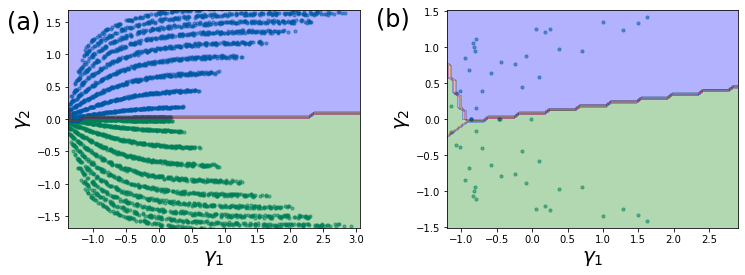

In [20]:
sx1 = Xtes[:,0]
sx2 = Xtes[:,1]

x1_min, x1_max = sx1.min(), sx1.max()
x2_min, x2_max = sx2.min(),sx2.max()
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, (x1_max-x1_min)/60),
                           np.arange(x2_min, x2_max, (x2_max-x2_min)/60))
xx3 = xx1-xx2
Z = lr_th.predict(np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()]).T)
Z = Z.reshape(xx1.shape)

fig = plt.figure(figsize=(12,4))
plt.rc('axes', labelsize=20) 
gs = fig.add_gridspec(1,2, wspace=0.30)
axs = gs.subplots()


axs[0].scatter(sx1,sx2,s=10,alpha=0.5,color='teal')
axs[0].contourf(xx1, xx2, Z, alpha=0.3,colors=['green','blue','red'])
axs[0].set(xlabel='$\gamma_1$', ylabel='$\gamma_2$')
axs[0].set_xlim(sx1.min()*0.95,sx1.max()*0.95)
axs[0].set_ylim(sx2.min()*0.95,sx2.max()*0.95)
axs[0].text(-2.3,1.4,'(a)',size=24)

sx1 = Xees[:,0]
sx2 = Xees[:,1]

x1_min, x1_max = sx1.min(), sx1.max()
x2_min, x2_max = sx2.min(),sx2.max()
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, (x1_max-x1_min)/60),
                           np.arange(x2_min, x2_max, (x2_max-x2_min)/60))
xx3 = xx1-xx2
Z = lr_ex.predict(np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()]).T)
Z = Z.reshape(xx1.shape)

axs[1].scatter(sx1,sx2,s=10,alpha=0.5,color='teal')
axs[1].contourf(xx1, xx2, Z, alpha=0.3,colors=['green','blue','red'])
axs[1].set(xlabel='$\gamma_1$', ylabel='$\gamma_2$')
axs[1].set_xlim(sx1.min()*0.95,sx1.max()*0.95)
axs[1].set_ylim(sx2.min()*0.95,sx2.max()*0.95)
axs[1].text(-2.2,1.3,'(b)',size=24)

plt.show()

# Neural network. Degree of polarization and intensity detection

# Theoretical data sets

# Right cicrularly polarized input and output standarized training and testing data. Initial weights used to train the whole neural network


In [21]:
#raw and standarized train input and output data
#for right circularly polarized light (P_e>=0)

ptra=tra[tra[:,1]>=0]
data = standarize(ptra)
Xtrr = data['Xr'] #raw input train data
Ytrr = data['Yr'] #raw output  train data
Xtrs = data['Xs'] #standarized input  train data
Ytrs = data['Ys'] #standarized output train data


# initial weights used to train
# the whole neural network
w0r = data['w0']   
b0r = data['b0']
wnr = data['wn']
bnr = data['bn']

#raw and standarized test input and output data
ptea=tea[tea[:,1]>=0]
data = standarize(ptea)
Xter = data['Xr'] #raw input test data
Yter = data['Yr'] #raw output test data
Xtes = data['Xs'] #normalized input test data
Ytes = data['Ys'] #normalized output test data

# Plot the Gamma parameter space

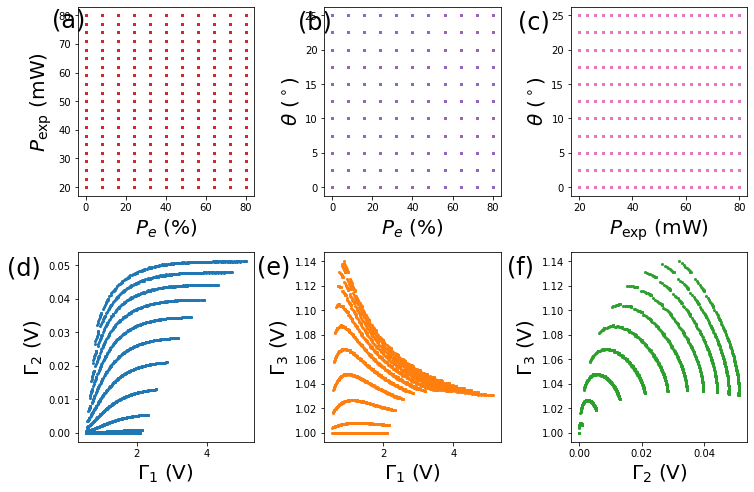

In [22]:
X1 = Xtrr[:,0]
X2 = Xtrr[:,1]
X3 = Xtrr[:,2]

Y1 = Ytrr[:,0]
Y2 = Ytrr[:,1]
Y3 = Ytrr[:,2]

s=16
fig = plt.figure(figsize=(12,8))
plt.rc('axes', labelsize=20) 
gs = fig.add_gridspec(2,3, hspace=0.30,wspace=0.40)
axs = gs.subplots()

axs[0,0].scatter(Y1,Y2,marker='.',s=s,color=colors[3])
axs[0,0].set(xlabel='$P_e$ (%)', ylabel='$P_{\mathrm{exp}}$ (mW)')
axs[0,0].text(-17,76,'(a)',size=24)

axs[0,1].scatter(Y1,Y3,marker='.',s=s,color=colors[4])
axs[0,1].set(xlabel='$P_e$ (%)', ylabel='$\\theta$ ($^\circ$)')
axs[0,1].text(-17,23,'(b)',size=24)

axs[0,2].scatter(Y2,Y3,marker='.',s=s,color=colors[6])
axs[0,2].set(xlabel='$P_{\mathrm{exp}}$ (mW)', ylabel='$\\theta$ ($^\circ$)')
axs[0,2].text(-3,23,'(c)',size=24)

axs[1,0].scatter(X1,X2,marker='.',s=s,color=colors[0])
axs[1,0].set(xlabel='$\Gamma_1$ (V)', ylabel='$\Gamma_2$ (V)')
axs[1,0].text(-1.7,0.047,'(d)',size=24)

axs[1,1].scatter(X1,X3,marker='.',s=s,color=colors[1])
axs[1,1].set(xlabel='$\Gamma_1$ (V)', ylabel='$\Gamma_3$ (V)')
axs[1,1].text(-1.6,1.13,'(e)',size=24)

axs[1,2].scatter(X2,X3,marker='.',s=s,color=colors[2])
axs[1,2].set(xlabel='$\Gamma_2$ (V)', ylabel='$\Gamma_3$ (V)')
axs[1,2].text(-0.023,1.13,'(f)',size=24)


plt.show()

# Right circularly polarized light. Neural network model  between the two ReLU layers

In [23]:
model_right_th = gen_model()


# Setup optimizer

In [24]:
adm=optimizers.Adamax(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_right_th.compile(loss='mean_squared_error', optimizer=adm, metrics=['accuracy'])


# Train neural network model with out ReLU layers for right circularly polarized light

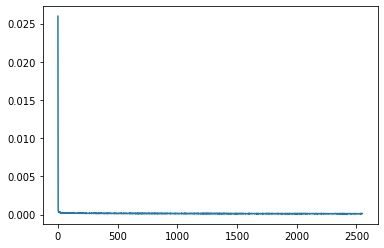

In [25]:
history=model_right_th.fit(Xtrs[:,(0,1,2)],Ytrs[:,(0,1)],epochs=2550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])


# Plot predictions and compare with the true values

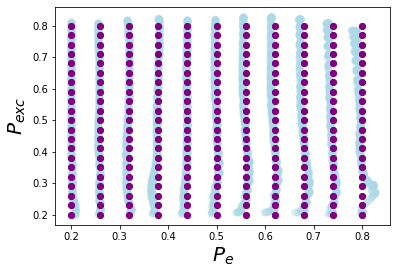

In [26]:
plot_predictions(model_right_th,Xtrs,Ytrs)


# Calculate errors comparing with the testing data set

In [27]:
errors=get_errors(model_right_th,Xtes[:,(0,1,2)],Ytes[:,(0,1)],mode='average')


errors min: [0.00055103 0.00804044]
errors max: [ 9.73474632 12.93883383]
errors av: [0.00661709 0.09256597]


# Error distribution

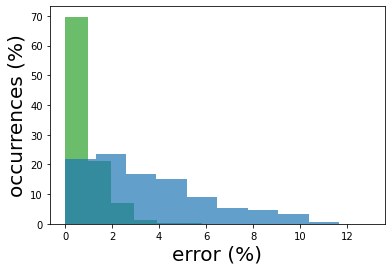

In [28]:
plot_error_distribution(model_right_th,Xtes[:,(0,1,2)],Ytes[:,(0,1)])


# Right circularly polarized light. Neural network model WITH the two ReLU layers

In [29]:
model_relu_right_th = gen_model_relu(model_right_th,w0r,b0r,wnr,bnr)


# Setup optimizer

In [30]:
adm_relu=optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_relu_right_th.compile(loss='mean_squared_error', optimizer=adm_relu, metrics=['accuracy'])


# Train neural network model WITH ReLU layers for right circularly polarized light

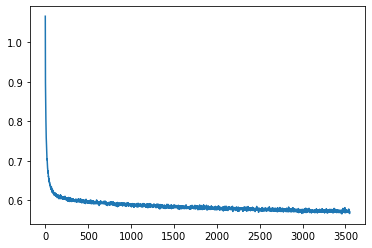

In [31]:
history=model_relu_right_th.fit(Xtrr[:,(0,1,2)],Ytrr[:,(0,1)],epochs=3550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])


# Plot predictions and compare with the true values

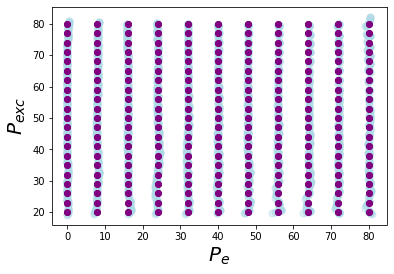

In [32]:
plot_predictions(model_relu_right_th,Xtrr[:,(0,1,2)],Ytrr[:,(0,1)])

# Calculate errors comparing with the testing data set

In [33]:
errors=get_errors(model_relu_right_th,Xter[:,(0,1,2)],Yter[:,(0,1)],mode='average')


errors min: [0.         0.00026684]
errors max: [2.96931603 9.31014333]
errors av: [0.12206952 2.20952364]


# Error distribution

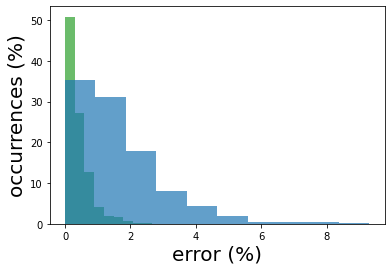

In [34]:
plot_error_distribution(model_relu_right_th,Xter[:,(0,1,2)],Yter[:,(0,1)])

# Left cicrularly polarized light input and output standarized training and testing data. Initial weights used to train the neural network WITH the two ReLU layers

In [35]:
#raw and standarized train input and output data
#for left circularly polarized light (P_e>=0)

ntra  = tra[tra[:,1]<0]
ntrat = np.transpose(ntra)
#change the sign of the polarization
#this step is important to be able to use the ReLU layers
#which filter any negative number
ntra = np.transpose([-ntrat[0],ntrat[1],ntrat[2],-ntrat[3],ntrat[4],ntrat[5],ntrat[6]])
data = standarize(ntra)
Xtrr = data['Xr'] #raw input train data
Ytrr = data['Yr'] #raw output  train data
Xtrs = data['Xs'] #normalized input  train data
Ytrs = data['Ys'] #normalized output train data

# initial weights used to train
# the whole neural network
w0l = data['w0']
b0l = data['b0']
wnl = data['wn']
bnl = data['bn']

#raw and standarized test input and output data
ntea  = tea[tea[:,1]<0]
nteat = np.transpose(ntea)
#change the sign of the polarization
#this step is important to be able to use the ReLU layers
#which filter any negative number
ntea = np.transpose([-nteat[0],nteat[1],nteat[2],-nteat[3],nteat[4],nteat[5],nteat[6]])
data = standarize(ntea)
Xter = data['Xr'] #raw input test data
Yter = data['Yr'] #raw output test data
Xtes = data['Xs'] #normalized input test data
Ytes = data['Ys'] #normalized output test data

# Left circularly polarized light. Neural network model WITH OUT the two ReLU layers

In [36]:
model_left_th = gen_model()

# Setup optimizer 

In [37]:
adm=optimizers.Adamax(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_left_th.compile(loss='mean_squared_error', optimizer=adm, metrics=['accuracy'])


# Train neural network for left circularly polarized light 

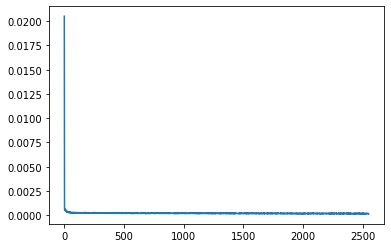

In [38]:
history=model_left_th.fit(Xtrs[:,(0,1,2)],Ytrs[:,(0,1)],epochs=2550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])


# Plot predictions and compare with the true values

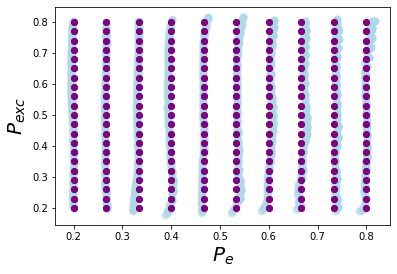

In [39]:
plot_predictions(model_left_th,Xtrs[:,(0,1,2)],Ytrs[:,(0,1)])


# Calculate errors comparing with the testing data set

In [40]:
errors=get_errors(model_left_th,Xtes[:,(0,1,2)],Ytes[:,(0,1)],mode='average')


errors min: [0.00163336 0.00053081]
errors max: [5.10224267 9.98421328]
errors av: [0.01950475 0.05707825]


# Error distribution

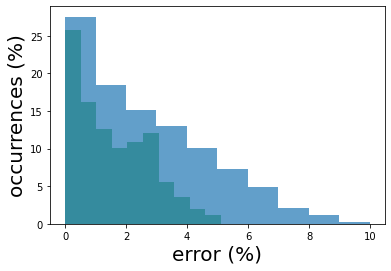

In [41]:
plot_error_distribution(model_left_th,Xtes[:,(0,1,2)],Ytes[:,(0,1)])


# Left circularly polarized light. Neural network model WITH the two ReLU layers

In [42]:
model_relu_left_th = gen_model_relu(model_left_th,w0l,b0l,wnl,bnl)


# Setup uptimizer

In [43]:
adm_relu=optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_relu_left_th.compile(loss='mean_squared_error', optimizer=adm_relu, metrics=['accuracy'])


# Train neural network model WITH ReLU layers for left circularly polarized light

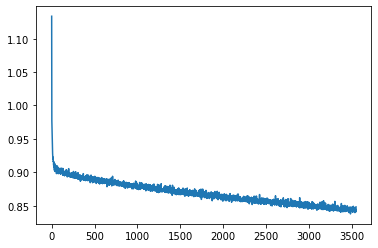

In [44]:
history=model_relu_left_th.fit(Xtrr[:,(0,1,2)],Ytrr[:,(0,1)],epochs=3550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])


# Plot predictions and compare with the true values

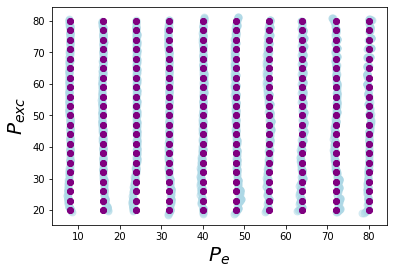

In [45]:
plot_predictions(model_relu_left_th,Xtrr[:,(0,1,2)],Ytrr[:,(0,1)])


# Calculate errors comparing with the testing data set

In [46]:
errors=get_errors(model_relu_left_th,Xter[:,(0,1,2)],Yter[:,(0,1)],mode='average')


errors min: [0.00050517 0.00037336]
errors max: [3.43339516 9.43114812]
errors av: [0.21566441 3.19028334]


# Error distribution

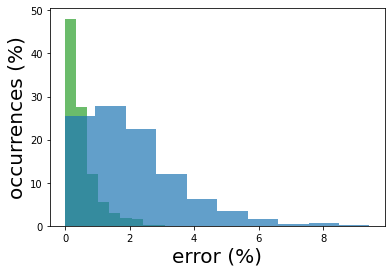

In [47]:
plot_error_distribution(model_relu_left_th,Xter[:,(0,1,2)],Yter[:,(0,1)])


# Experimental data sets

# Right cicrularly polarized input and output standarized training and testing data. Initial weights used to train the whole neural network


In [48]:
#raw and standarized train input and output data
#for right circularly polarized light (P_e=0)

pera = era[era[:,1]>=0]
data = standarize(pera)
Xtrr = data['Xr'] #raw input train data
Ytrr = data['Yr'] #raw output  train data
Xtrs = data['Xs'] #standarized input  train data
Ytrs = data['Ys'] #standarized output train data

# initial weights used to train
# the whole neural network
w0r = data['w0']   
b0r = data['b0']
wnr = data['wn']
bnr = data['bn']

#raw and standarized test input and output data
peea = eea[eea[:,1]>=0]
data = standarize(peea)
Xter = data['Xr'] #raw input test data
Yter = data['Yr'] #raw output test data
Xtes = data['Xs'] #normalized input test data
Ytes = data['Ys'] #normalized output test data


# Plot Gamma parameter space

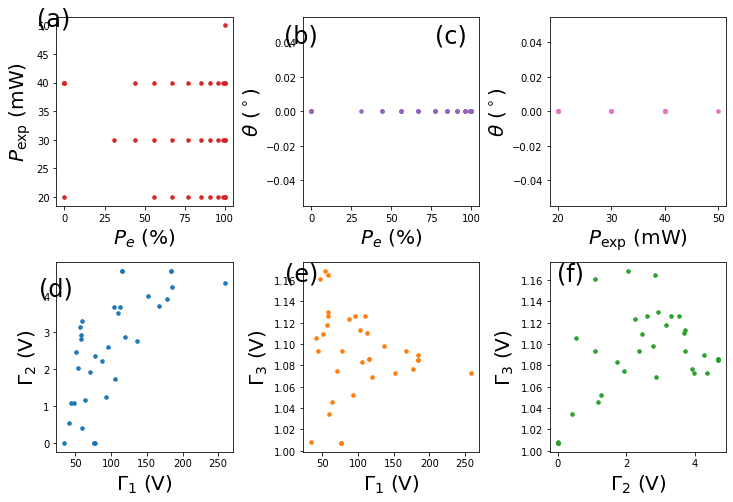

In [49]:
X1 = Xtrr[:,0]
X2 = Xtrr[:,1]
X3 = Xtrr[:,2]

Y1 = Ytrr[:,0]
Y2 = Ytrr[:,1]
Y3 = Ytrr[:,2]

s=50
fig = plt.figure(figsize=(12,8))
plt.rc('axes', labelsize=20) 
gs = fig.add_gridspec(2,3, hspace=0.30,wspace=0.40)
axs = gs.subplots()

axs[0,0].scatter(Y1,Y2,marker='.',s=s,color=colors[3])
axs[0,0].set(xlabel='$P_e$ (%)', ylabel='$P_{\mathrm{exp}}$ (mW)')
axs[0,0].text(-17,50,'(a)',size=24)

axs[0,1].scatter(Y1,Y3,marker='.',s=s,color=colors[4])
axs[0,1].set(xlabel='$P_e$ (%)', ylabel='$\\theta$ ($^\circ$)')
axs[0,1].text(-17,0.04,'(b)',size=24)

axs[0,2].scatter(Y2,Y3,marker='.',s=s,color=colors[6])
axs[0,2].set(xlabel='$P_{\mathrm{exp}}$ (mW)', ylabel='$\\theta$ ($^\circ$)')
axs[0,2].text(-3,0.04,'(c)',size=24)

axs[1,0].scatter(X1,X2,marker='.',s=s,color=colors[0])
axs[1,0].set(xlabel='$\Gamma_1$ (V)', ylabel='$\Gamma_2$ (V)')
axs[1,0].text(-1.7,4.0,'(d)',size=24)

axs[1,1].scatter(X1,X3,marker='.',s=s,color=colors[1])
axs[1,1].set(xlabel='$\Gamma_1$ (V)', ylabel='$\Gamma_3$ (V)')
axs[1,1].text(-1.6,1.16,'(e)',size=24)

axs[1,2].scatter(X2,X3,marker='.',s=s,color=colors[2])
axs[1,2].set(xlabel='$\Gamma_2$ (V)', ylabel='$\Gamma_3$ (V)')
axs[1,2].text(-0.023,1.16,'(f)',size=24)


plt.show()

# Right circularly polarized light. Neural network model between the two ReLU layers

In [50]:
model_right_ex = gen_model()


# Setup optimizer

In [51]:
adm=optimizers.Adamax(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_right_ex.compile(loss='mean_squared_error', optimizer=adm, metrics=['accuracy'])

# Train neural network model with out ReLU layers for right circularly polarized light

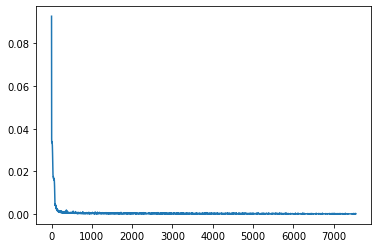

In [52]:
history=model_right_ex.fit(Xtrs[:,(0,1,2)],Ytrs[:,(0,1)],epochs=7550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])

# Plot predictions and compare with true values

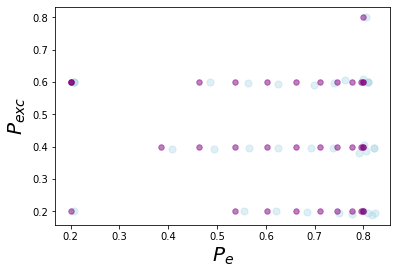

In [53]:
plot_predictions(model_right_ex,Xtrs[:,(0,1,2)],Ytrs[:,(0,1)])


# Calculate errors comparing with the testing data set

In [54]:
errors=get_errors(model_right_ex,Xtes[:,(0,1,2)],Ytes[:,(0,1)],mode='average')


errors min: [0.28574163 0.32580226]
errors max: [ 9.8121361  43.51130313]
errors av: [0.16516129 0.4941561 ]


# Error distribution

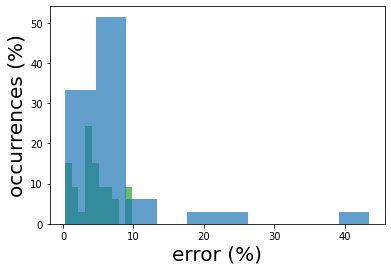

In [55]:
plot_error_distribution(model_right_ex,Xtes[:,(0,1,2)],Ytes[:,(0,1)])

# Right circularly polarized light. Neural network model WITH the two ReLU layers

In [56]:
model_relu_right_ex=gen_model_relu(model_right_ex,w0r,b0r,wnr,bnr)


# Set up optimizer

In [57]:
adm_relu=optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_relu_right_ex.compile(loss='mean_squared_error', optimizer=adm_relu, metrics=['accuracy'])


# Train neural network model WITH ReLU layers for right circularly polarized light

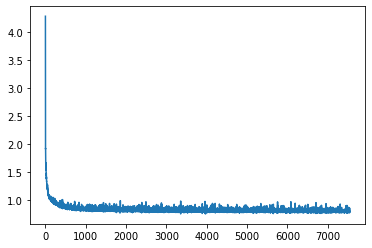

In [58]:
history=model_relu_right_ex.fit(Xtrr[:,(0,1,2)],Ytrr[:,(0,1)],epochs=7550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])


# Plot predictions and compare with the true values

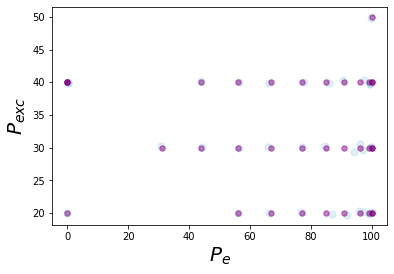

In [59]:
plot_predictions(model_relu_right_ex,Xtrr[:,(0,1,2)],Ytrr[:,(0,1)])


# Calculate errors comparing with the testing data set

In [60]:
errors=get_errors(model_relu_right_ex,Xter[:,(0,1,2)],Yter[:,(0,1)],mode='average')


errors min: [0.         0.03621615]
errors max: [ 5.64378494 30.08200242]
errors av: [2.40843221 9.69520116]


# Error distribution

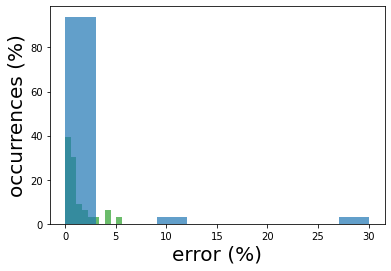

In [61]:
plot_error_distribution(model_relu_right_ex,Xter[:,(0,1,2)],Yter[:,(0,1)])


# Left circularly polarized light. Neural network model WITH the two ReLU layers

In [62]:
#raw and standarized train input and output data
#for right circularly polarized light (P_e=0)

nera = era[era[:,1]<0]
nerat = np.transpose(nera)
#change the sign of the polarization
#this step is important to be able to use the ReLU layers
#which filter any negative number
nera = np.transpose([nerat[0],-nerat[1],nerat[2],-nerat[3],nerat[4],nerat[5],nerat[6]])
data = standarize(nera)
Xtrr = data['Xr'] #raw input train data
Ytrr = data['Yr'] #raw output  train data
Xtrs = data['Xs'] #standarized input  train data
Ytrs = data['Ys'] #standarized output train data

# initial weights used to train
# the whole neural network
w0l = data['w0']   
b0l = data['b0']
wnl = data['wn']
bnl = data['bn']

#raw and standarized test input and output data
neea = eea[eea[:,1]<0]
neeat = np.transpose(neea)
#change the sign of the polarization
#this step is important to be able to use the ReLU layers
#which filter any negative number
neea = np.transpose([neeat[0],-neeat[1],neeat[2],-neeat[3],neeat[4],neeat[5],neeat[6]])
data = standarize(neea)
Xter = data['Xr'] #raw input test data
Yter = data['Yr'] #raw output test data
Xtes = data['Xs'] #normalized input test data
Ytes = data['Ys'] #normalized output test data


# Left circularly polarized light. Neural network model between the two ReLU layers

In [63]:
model_left_ex = gen_model()


# Setup optimizer

In [64]:
adm=optimizers.Adamax(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_left_ex.compile(loss='mean_squared_error', optimizer=adm, metrics=['accuracy'])

# Train neural network model WITH ReLU layers for left circularly polarized light

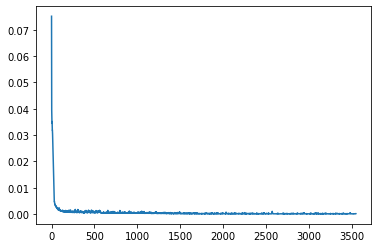

In [65]:
history=model_left_ex.fit(Xtrs[:,(0,1,2)],Ytrs[:,(0,1)],epochs=3550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])

# Plot predictions and compare with true values

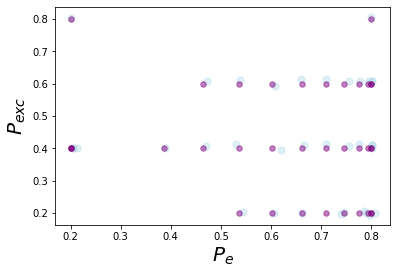

In [66]:
plot_predictions(model_left_ex,Xtrs[:,(0,1,2)],Ytrs[:,(0,1)])

# Calculate errors comparing with the testing data set

In [67]:
errors=get_errors(model_left_ex,Xtes[:,(0,1,2)],Ytes[:,(0,1)],mode='average')

errors min: [0.13512003 0.25847098]
errors max: [12.32974518 25.12847872]
errors av: [0.13470242 0.3675415 ]


# Error distribution

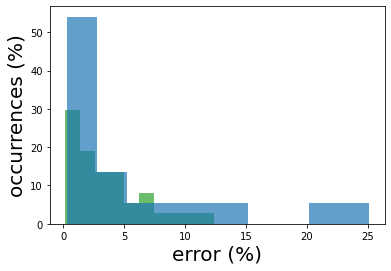

In [68]:
plot_error_distribution(model_left_ex,Xtes[:,(0,1,2)],Ytes[:,(0,1)])

# Left circularly polarized light. Neural network model WITH the two ReLU layers

In [69]:
model_relu_left_ex=gen_model_relu(model_left_ex,w0l,b0l,wnl,bnl)

# Setup uptimizer

In [70]:
adm_relu=optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model_relu_left_ex.compile(loss='mean_squared_error', optimizer=adm_relu, metrics=['accuracy'])


# Train neural network model WITH ReLU layers for right circularly polarized light

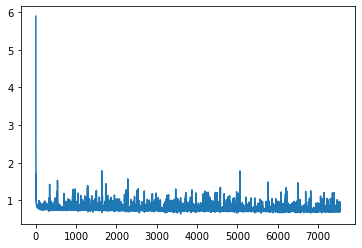

In [71]:
history=model_relu_left_ex.fit(Xtrr[:,(0,1,2)],Ytrr[:,(0,1)],epochs=7550, batch_size = 10,verbose=0)
plt.plot(history.history['loss'])

# Plot predictions and compare with true values

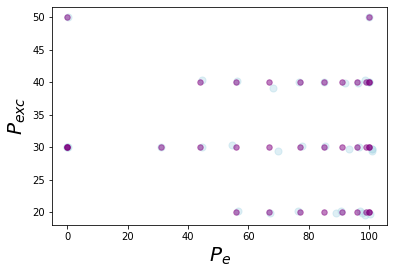

In [72]:
plot_predictions(model_relu_left_ex,Xtrr[:,(0,1,2)],Ytrr[:,(0,1)])

# Calculate errors comparing with the testing data set

In [73]:
errors=get_errors(model_relu_left_ex,Xter[:,(0,1,2)],Yter[:,(0,1)],mode='average')

errors min: [0.         0.06440294]
errors max: [11.26591741 11.47611026]
errors av: [4.741218   3.83295698]


# Error distribution

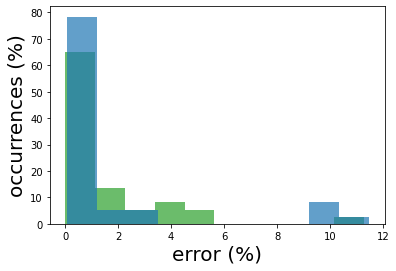

In [74]:
plot_error_distribution(model_relu_left_ex,Xter[:,(0,1,2)],Yter[:,(0,1)])